In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco
from datetime import datetime
import random
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#Get data
df = pd.read_csv("HK0386_montly.csv",index_col = "Date")
df = pd.DataFrame(df['Close'])

In [5]:
df.index = pd.to_datetime(df.index).date

In [7]:
#define training and test set length
train_len = len(df['Close'])-12
test_len = len(df['Close'])-6

In [9]:
df

,Close
2000-10-30,0.303460
2000-11-29,0.279021
2000-12-28,0.244398
2001-01-30,0.230141
2001-02-27,0.266801
...,...
2024-08-29,5.134777
2024-09-27,4.860000
2024-10-30,4.360000
2024-11-28,4.170000


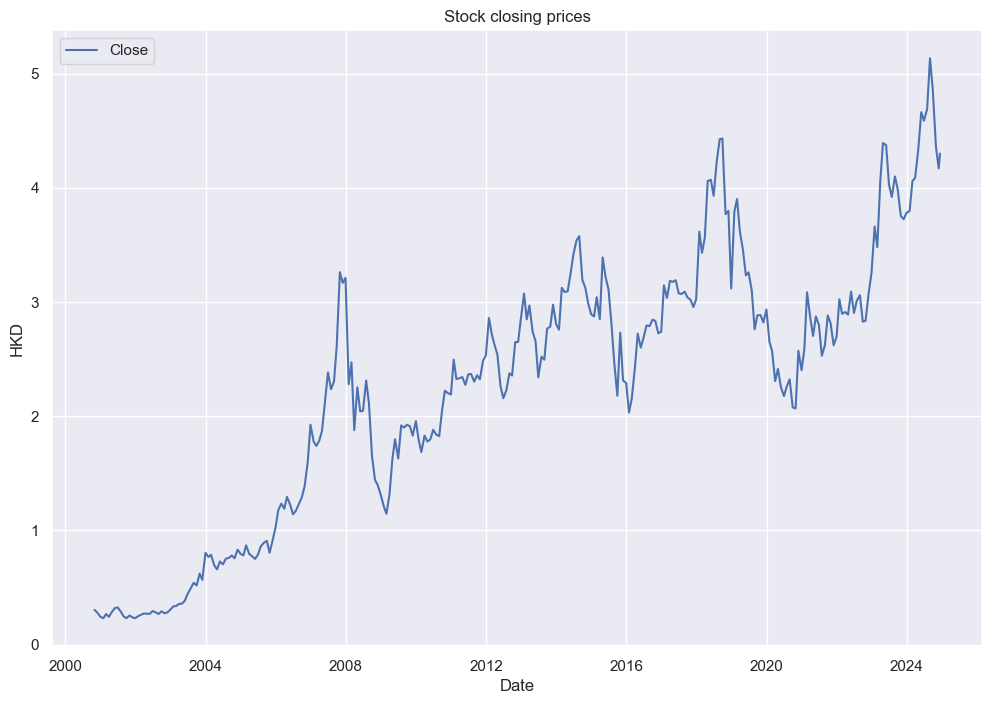

In [11]:
#stock price visualization
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('HKD')
plt.title('Stock closing prices')
plt.show()

<Figure size 640x480 with 0 Axes>

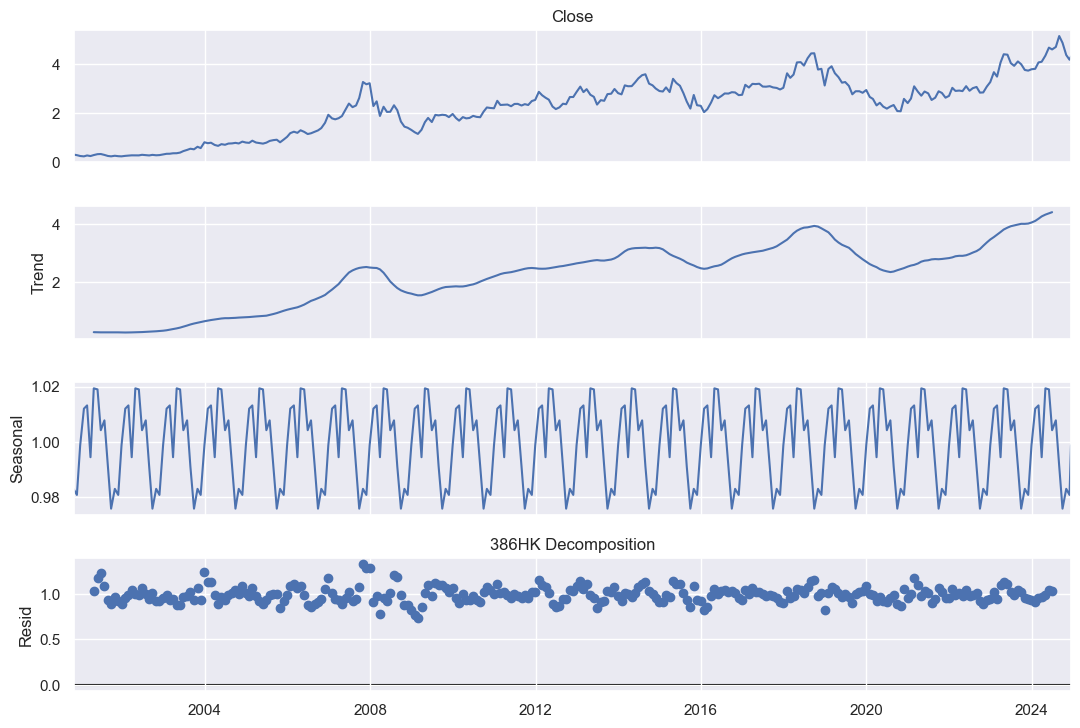

In [13]:
#Seasonal Decomposition

result = seasonal_decompose(df['Close'], model='multiplicative',period=12)
fig = plt.figure()  
fig = result.plot()  
plt.title("386HK Decomposition") 
fig.set_size_inches(12, 8)
plt.show()

We observed trend and seasonality in our data.

# Checking close price data for normality and stationarity
1.ADF test

2.Normality Test

# ADF test
Augmented Dickey Fuller(ADF) test is a common statistical test used to test whether a given Time series is stationary or not.

In [17]:
result = adfuller(df['Close'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
  print ("Reject Null Hypothesis. So, Time Series is Stationary")
else:
  print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
print("\n")

ADF Statistic: -1.445597
p-value: 0.560232
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




# Normality Test

In [20]:
stat, p = normaltest(df['Close'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed(reject H0)')
print('\n')

Statistics=15.936, p=0.000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)




# log Transformation
The log transformation can be used to make highly skewed distributions less skewed.

In [23]:
df_log = np.log(df / df.shift(1))

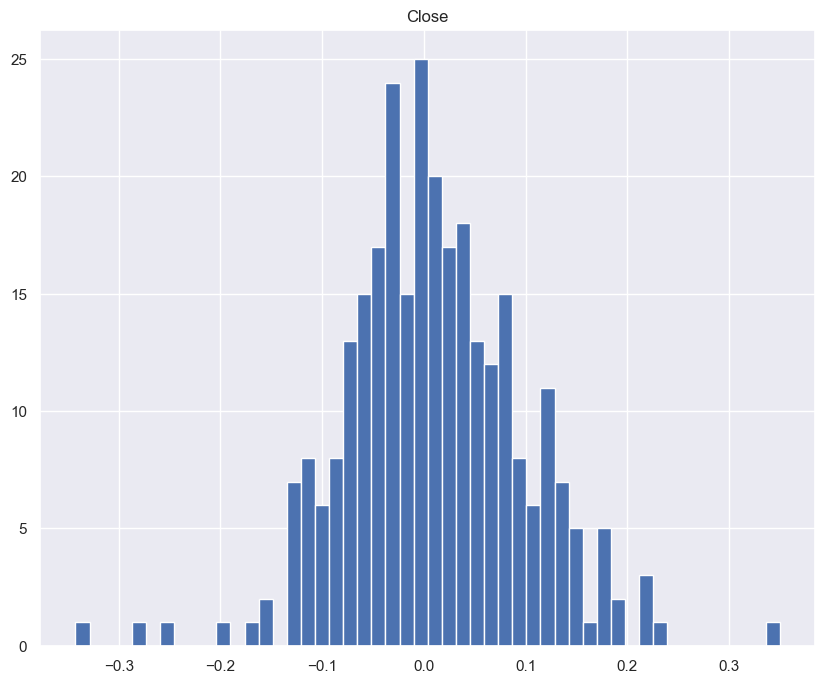

In [25]:
df_log.hist(bins=50, figsize=(10, 8))
plt.show()

In [27]:
df_log2 = df_log.dropna()


df_log2.head()

,Close
2000-11-29,-0.083964
2000-12-28,-0.132490
2001-01-30,-0.060104
2001-02-27,0.147810
2001-03-29,-0.096074


# Using the log transformed data to do ADF and Normality test

In [30]:
result = adfuller(df_log2['Close'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
  print ("Reject Null Hypothesis. So, Time Series is Stationary")
else:
  print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
print("\n")

ADF Statistic: -11.531149
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Reject Null Hypothesis. So, Time Series is Stationary




In [32]:
stat, p = normaltest(df_log2['Close'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed(reject H0)')
print('\n')

Statistics=10.809, p=0.004
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)




We can see that now the data for all three stocks is stationary. But it is not normally distributed. Have to look into why this is happening.

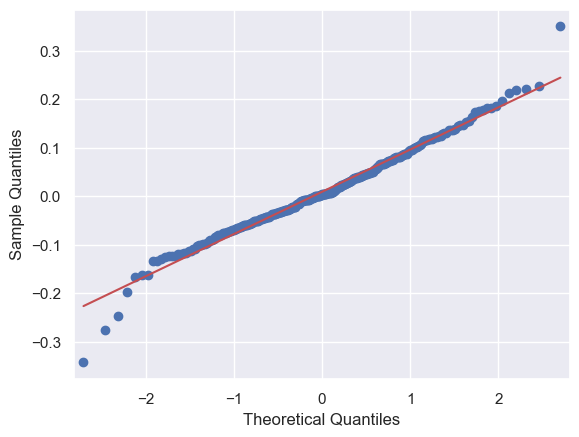

In [35]:
fig = sm.qqplot(df_log2['Close'], line='s')
plt.show()

We can see that most of the points lie mostly along the straight diagonal line with some minor deviations along each of the tails.

Based on this plot, we could assume that it is a closed normally distributed.

In [38]:
#if not stationary then eliminate trend
#Eliminate trend
'''
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
#df_log = np.log(df)
moving_avg = df_log2.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()
'''

'\nfrom pylab import rcParams\nrcParams[\'figure.figsize\'] = 10, 6\n#df_log = np.log(df)\nmoving_avg = df_log2.rolling(12).mean()\nstd_dev = df_log.rolling(12).std()\nplt.legend(loc=\'best\')\nplt.title(\'Moving Average\')\nplt.plot(std_dev, color ="black", label = "Standard Deviation")\nplt.plot(moving_avg, color="red", label = "Mean")\nplt.legend()\nplt.show()\n'

In [40]:
'''
train_data=pd.DataFrame() # splitting into test and train data
test_data=pd.DataFrame()
train_data['Close'], test_data['Close'] = df['Close'][1:int(len(df['Close']*0.8))], df['Close'][int(len(df)*0.8):]
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
'''

"\ntrain_data=pd.DataFrame() # splitting into test and train data\ntest_data=pd.DataFrame()\ntrain_data['Close'], test_data['Close'] = df['Close'][1:int(len(df['Close']*0.8))], df['Close'][int(len(df)*0.8):]\nmodel_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,\n                      test='adf',       # use adftest to find optimal 'd'\n                      max_p=3, max_q=3, # maximum p and q\n                      m=1,              # frequency of series\n                      d=None,           # let model determine 'd'\n                      seasonal=True,   # Seasonality\n                      start_P=0, \n                      D=0, \n                      trace=True,\n                      error_action='ignore',  \n                      suppress_warnings=True, \n                      stepwise=True)\n\nprint(model_autoARIMA.summary())\nmodel_autoARIMA.plot_diagnostics(figsize=(15,8))\nplt.show()\n"

# Constructing an ARIMA model with auto-fitting parameters (p,d,q)

In [43]:
from pmdarima import auto_arima

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-99.378, Time=3.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.079, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.198, Time=0.04 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.928, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.996, Time=0.04 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-96.552, Time=1.94 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-96.548, Time=1.25 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.70 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-96.618, Time=1.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-98.507, Time=0.13 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-94.808, Time=0.31 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-94.792, Time=0.38 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-91.155, Time=0.59 sec


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-96.628, Time=0.21 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 14.763 seconds


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                   0
2024-01-30  3.798726
2024-02-28  3.798897
2024-03-27  3.816321
2024-04-29  3.818386
2024-05-30  3.834896
2024-06-27  3.838555
2024-07-30  3.854306
2024-08-29  3.859307
2024-09-27  3.874431
2024-10-30  3.880560
2024-11-28  3.895165
2024-12-11  3.902244


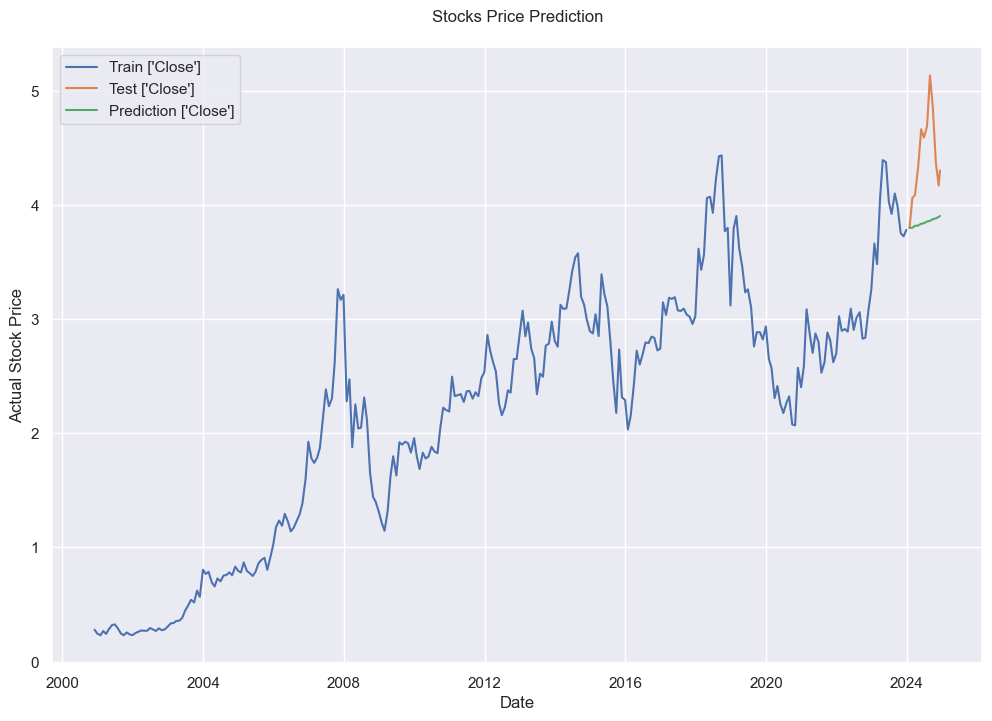

In [45]:

train_data1=pd.DataFrame() # splitting into test and train data
test_data1=pd.DataFrame() 
plt.figure(figsize=(12,8))

train_data1['Close'], test_data1['Close'] = df['Close'][1:train_len], df['Close'][train_len:]
autoARIMA = auto_arima(train_data1['Close'], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True)
autoARIMA.fit(train_data1['Close'].values) # fitting the model
forecast1 = autoARIMA.predict(n_periods=len(test_data1['Close']))
forecast1 = pd.DataFrame(forecast1,index = test_data1.index) # plot the predictions for validation set
plt.plot(train_data1, label='Train {}'.format(['Close']))
plt.plot(test_data1, label='Test {}'.format(['Close']))
plt.plot(forecast1, label='Prediction {}'.format(['Close']))

print(forecast1)

plt.title('Stocks Price Prediction\n')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


Auto-Arima does not perform well. Let's take a look at the performance report and diagnostics.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  278
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  55.689
Date:                Wed, 18 Dec 2024   AIC                            -99.378
Time:                        16:37:05   BIC                            -77.634
Sample:                             0   HQIC                           -90.654
                                - 278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      2.414      0.016       0.000       0.003
ar.L1          0.0104      0.131      0.080      0.937      -0.246       0.266
ar.L2          0.8464      0.115      7.387      0.0

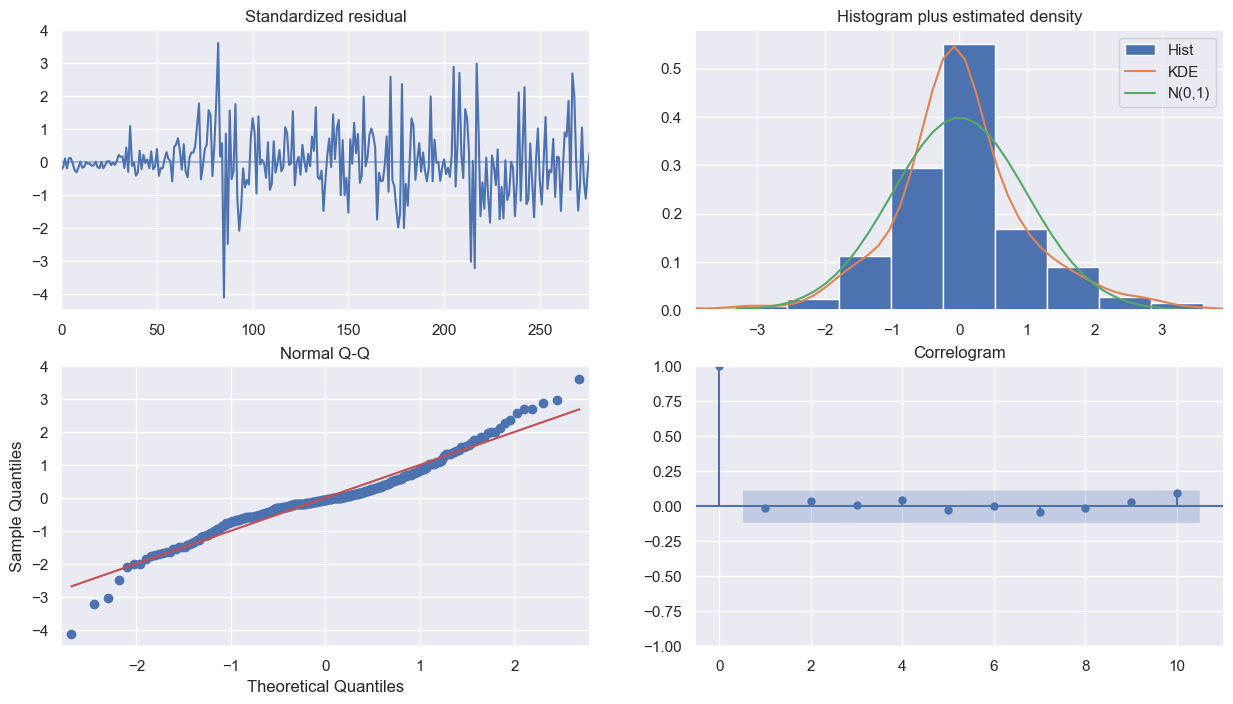

In [47]:
print(autoARIMA.summary())
autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Histogram:
Observations: The distribution is relatively symmetrical, more peaked than a normal distribution, with a heavy right tail.

The density curve (a smooth estimate of the residual distribution) compared to N(0,1) shows no significant skewness (skewness is close to 0), which is a positive sign, indicating the model does not systematically overestimate or underestimate.

The probability density is higher near the mean, suggesting that the residuals are concentrated around 0 and the model fits most data points well. However, if the peak significantly exceeds that of a normal distribution, this is referred to as "leptokurtic," meaning kurtosis is greater than 3.

Possible reasons: There are fewer outliers, but more residuals are close to the mean (0).
QQ-plot:

Heavy right tail (upper tail lifted): Indicates the data might have a right skew or heavy-tailed distribution (e.g., Gamma distribution or log-normal distribution). This suggests extreme large values occur more frequently, which is uncommon in a normal distribution.
Left side bends downward: Suggests sparse data on the left side, potentially lacking negative or extremely small values, indicating the distribution may be truncated or have poor symmetry.
Correlogram:
The residuals remain within the blue bands, indicating no significant autocorrelation in the residuals.

Standard Residual:
Trends and seasonality are still observable in the residuals.

Histogram: 观察特性：较为对称，比正态分布尖，右有重尾

1.密度曲线（残差分布的平滑估计）对比N(0,1)没有明显的偏态（skewness接近0），这是一个好的现象，说明模型没有系统性地高估或低估

2.分布在均值附近的概率密度较高，说明残差集中在0附近，模型对大多数数据点拟合较好。
但是，如果高峰明显超过正态分布，这种情况称为“尖峰”（leptokurtic），即峰度（kurtosis）大于3。
可能原因: 数据中异常值较少，但有更多的残差值接近于均值（0）。

QQ-plot:

尾部重（右尾翘起）：说明数据可能存在右偏或重尾分布（例如伽马分布、对数正态分布）。这意味着极端大值的出现频率较高，而这在正态分布中并不常见。

左侧弯下去：说明在左侧数据较为稀少，可能缺少负值或极小值，这表明数据的分布可能有一个截断或对称性较差。

Correlogram:
残差没有超出蓝色范围，残差无显著自相关性

Standard Residual:
依旧能观察到trend和seasonality

In [50]:
from scipy.stats import kurtosis

kurt = kurtosis(autoARIMA.resid(), fisher=True)  # fisher=True 返回 Fisher 定义的峰度
print("峰度值:", kurt)

峰度值: 2.0682591583287344


The results are unsatisfactory, so we will discontinue the use of autoARIMA.

效果不好，直接不用autoARIMA了

## Try SARIMA

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  278
Model:             SARIMAX(1, 2, 3)x(1, 2, [1], 12)   Log Likelihood                 -69.856
Date:                              Wed, 18 Dec 2024   AIC                            155.712
Time:                                      16:37:08   BIC                            183.947
Sample:                                           0   HQIC                           167.073
                                              - 278                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -4.9e-06   5.61e-06     -0.873      0.383   -1.59e-05     6.1e-06
ar.L1         -0.83

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


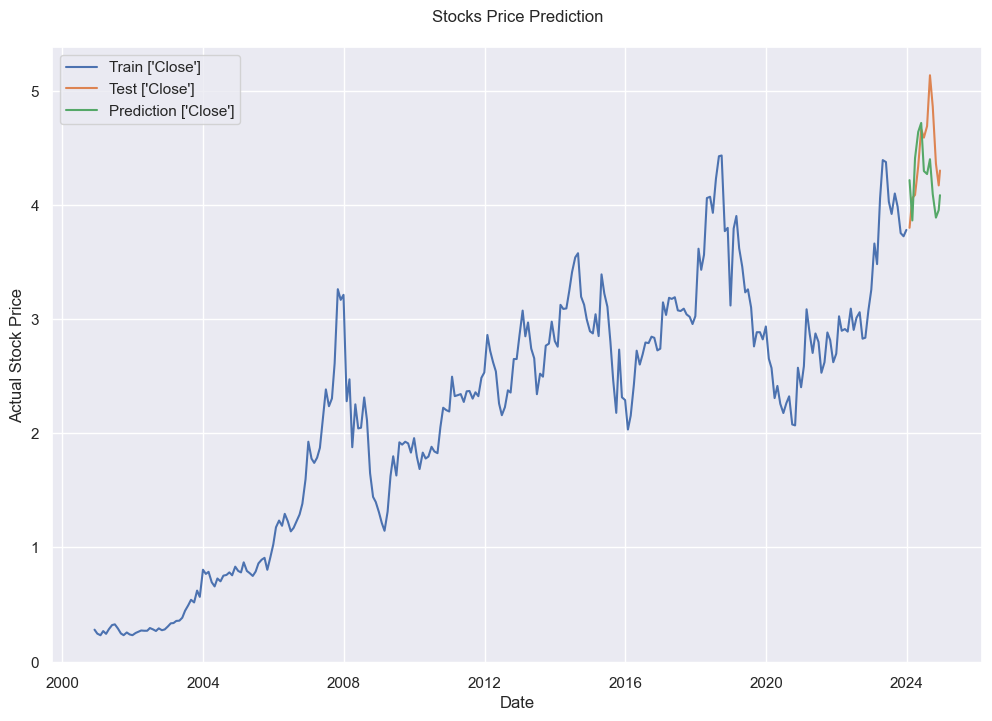

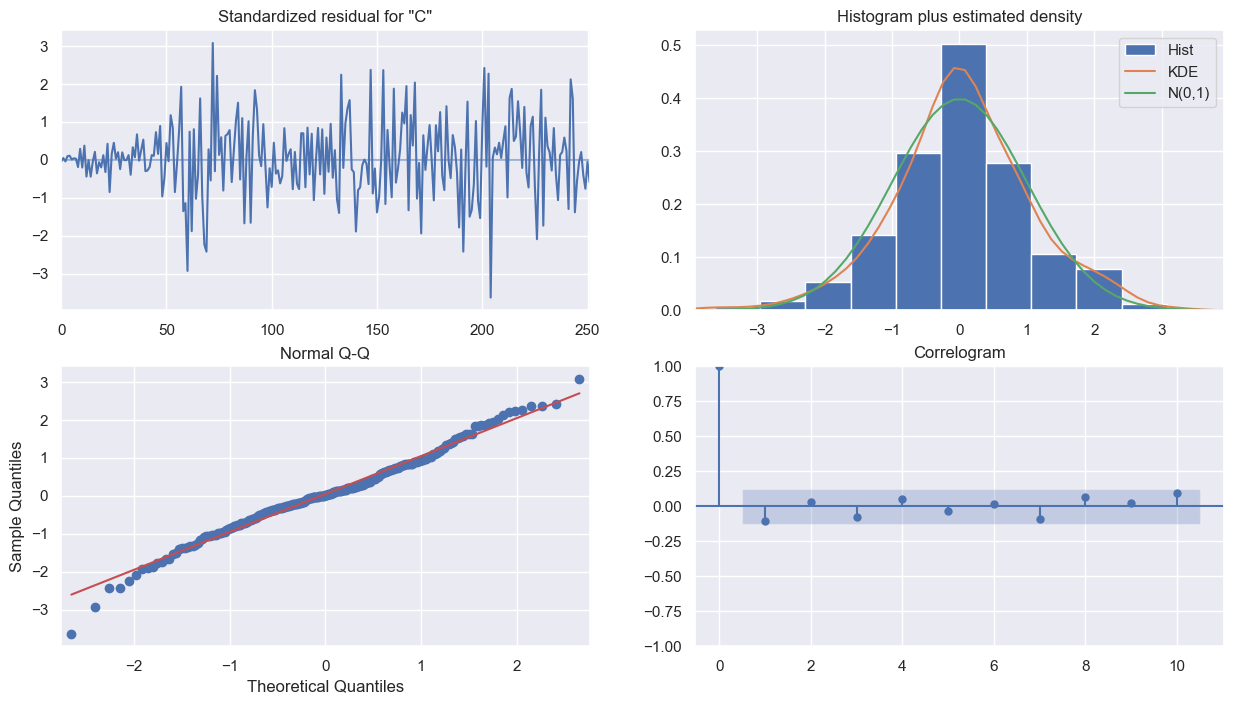

In [54]:
train_data=pd.DataFrame() # Splitting into test and train data 分割为测试集和训练集
test_data=pd.DataFrame() 
plt.figure(figsize=(12,8))

train_data['Close'], test_data['Close'] = df['Close'][1:train_len], df['Close'][train_len:]
# Set the seasonal parameters for the SARIMA model (P, D, Q, m)
# 设定SARIMA模型的季节性参数 (P, D, Q, m)
# For example, (1, 1, 1, 12) represents seasonal AR, seasonal differencing, and seasonal MA with a 12-month period
# 例如，(1, 1, 1, 12) 表示季节性自回归、季节性差分和季节性滑动平均项，周期为12个月
seasonal_order = (1, 2, 1, 12)

# Create the SARIMAX model
# 创建SARIMAX模型
SARIMA = sm.tsa.SARIMAX(train_data['Close'], 
                       order=(1, 2, 3),         # Non-seasonal part (AR, I, MA) 非季节性部分 (AR, I, MA)
                       seasonal_order=seasonal_order,  # Seasonal part (P, D, Q, m) 季节性部分 (P, D, Q, m)
                       trend='t')               # Linear trend (if modeling the trend is needed) 线性趋势（如果需要建模趋势的话）

# Fit the model
# 拟合模型
results = SARIMA.fit()

# Print model summary
# 打印模型摘要
print(results.summary())

# Forecast
# 进行预测
forecast = results.forecast(steps=len(test_data['Close']))


#forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Close']) # Plot the predictions for validation set 绘制验证集的预测结果
#print(forecast.isna().sum())  # Check for NaN values: 0 查看是否有 NaN 值:0
# Ensure the forecast index aligns with the test_data index
# 确保forecast的索引与test_data的索引对齐
forecast_df = forecast.to_frame(name='Close')

# Align indices if necessary to ensure matching
# 如果需要对齐索引，确保索引匹配
forecast_df.index = test_data.index

# Print the results
# 打印结果
plt.plot(train_data, label='Train {}'.format(['Close']))
plt.plot(test_data, label='Test {}'.format(['Close']))
plt.plot(forecast_df, label='Prediction {}'.format(['Close']))
plt.title('Stocks Price Prediction\n')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Check residual diagnostics
# 查看残差诊断
results.plot_diagnostics(figsize=(15, 8))
plt.show()


Try using random search to find suitable parameters

尝试使用random search寻找最合适的参数

In [81]:

train_data=pd.DataFrame() # splitting into test and train data
test_data=pd.DataFrame() 
plt.figure(figsize=(12,8))

train_data['Close'], test_data['Close'] = df['Close'][1:train_len], df['Close'][train_len:]

# 禁止所有警告
warnings.simplefilter("ignore")

# 设置随机种子，确保结果可复现
random.seed(42)  # 设置random模块的种子
np.random.seed(42)  # 设置numpy模块的种子

# 定义参数范围
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(0, 3)
seasonal_p_range = range(0, 3)
seasonal_d_range = range(0, 3)
seasonal_q_range = range(0, 3)
m_range = [12, 24]  # 假设季节性周期为12或24

best_aic = float('inf')
best_params = None

# 打印中间结果
print("开始随机搜索模型参数...\n")

for i in range(100):  # 随机选择100个组合
    p = random.choice(p_range)
    d = random.choice(d_range)
    q = random.choice(q_range)
    seasonal_p = random.choice(seasonal_p_range)
    seasonal_d = random.choice(seasonal_d_range)
    seasonal_q = random.choice(seasonal_q_range)
    m = random.choice(m_range)
    print(f"尝试参数组合 {i+1}: (p={p}, d={d}, q={q}, seasonal_p={seasonal_p}, seasonal_d={seasonal_d}, seasonal_q={seasonal_q}, m={m})")
    try:
        model = SARIMAX(train_data['Close'], 
                        order=(p, d, q),
                        seasonal_order=(seasonal_p, seasonal_d, seasonal_q, m))
        results = model.fit()
        #forecast = results.forecast(steps=len(test_data['Close']))
        
        
        # 获取AIC
        aic = results.aic
        print(f"  AIC = {aic}")
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q, seasonal_p, seasonal_d, seasonal_q, m)
            print(f"  新的最佳模型参数 (AIC: {best_aic})\n")

    except exception as e:
        print(f"  错误: {e}")
        continue

# 输出最终最佳参数
print("\n随机搜索完成！")
print(f"最优参数组合: {best_params}")
print(f"  最佳模型参数 (AIC: {best_aic})\n")


开始随机搜索模型参数...

尝试参数组合 1: (p=2, d=0, q=0, seasonal_p=2, seasonal_d=1, seasonal_q=0, m=12)
  AIC = 3.11928431541957
  新的最佳模型参数 (AIC: 3.11928431541957)

尝试参数组合 2: (p=0, d=2, q=0, seasonal_p=2, seasonal_d=2, seasonal_q=2, m=12)
  AIC = 235.1504355939236
尝试参数组合 3: (p=2, d=1, q=0, seasonal_p=0, seasonal_d=0, seasonal_q=0, m=12)
  AIC = -96.63412212216069
  新的最佳模型参数 (AIC: -96.63412212216069)

尝试参数组合 4: (p=2, d=2, q=0, seasonal_p=2, seasonal_d=0, seasonal_q=2, m=24)
  AIC = -6.1594867151494626
尝试参数组合 5: (p=0, d=1, q=2, seasonal_p=1, seasonal_d=0, seasonal_q=0, m=24)
  AIC = -94.34274518782746
尝试参数组合 6: (p=1, d=1, q=0, seasonal_p=0, seasonal_d=1, seasonal_q=0, m=12)
  AIC = 89.85386987302935
尝试参数组合 7: (p=1, d=0, q=1, seasonal_p=1, seasonal_d=2, seasonal_q=1, m=12)
  AIC = 74.20545960427941
尝试参数组合 8: (p=2, d=1, q=2, seasonal_p=0, seasonal_d=1, seasonal_q=0, m=24)
  AIC = 91.91234774788335
尝试参数组合 9: (p=2, d=2, q=1, seasonal_p=2, seasonal_d=0, seasonal_q=2, m=12)
  AIC = -87.37437218982419
尝试参数组合 

<Figure size 1200x800 with 0 Axes>

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  278
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  51.464
Date:                Wed, 18 Dec 2024   AIC                            -96.928
Time:                        16:38:50   BIC                            -86.056
Sample:                             0   HQIC                           -92.566
                                - 278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0126      0.011      1.154      0.249      -0.009       0.034
ma.L1         -0.0971      0.052     -1.879      0.060      -0.198       0.004
sigma2         0.0404      0.002     18.623      0.0

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


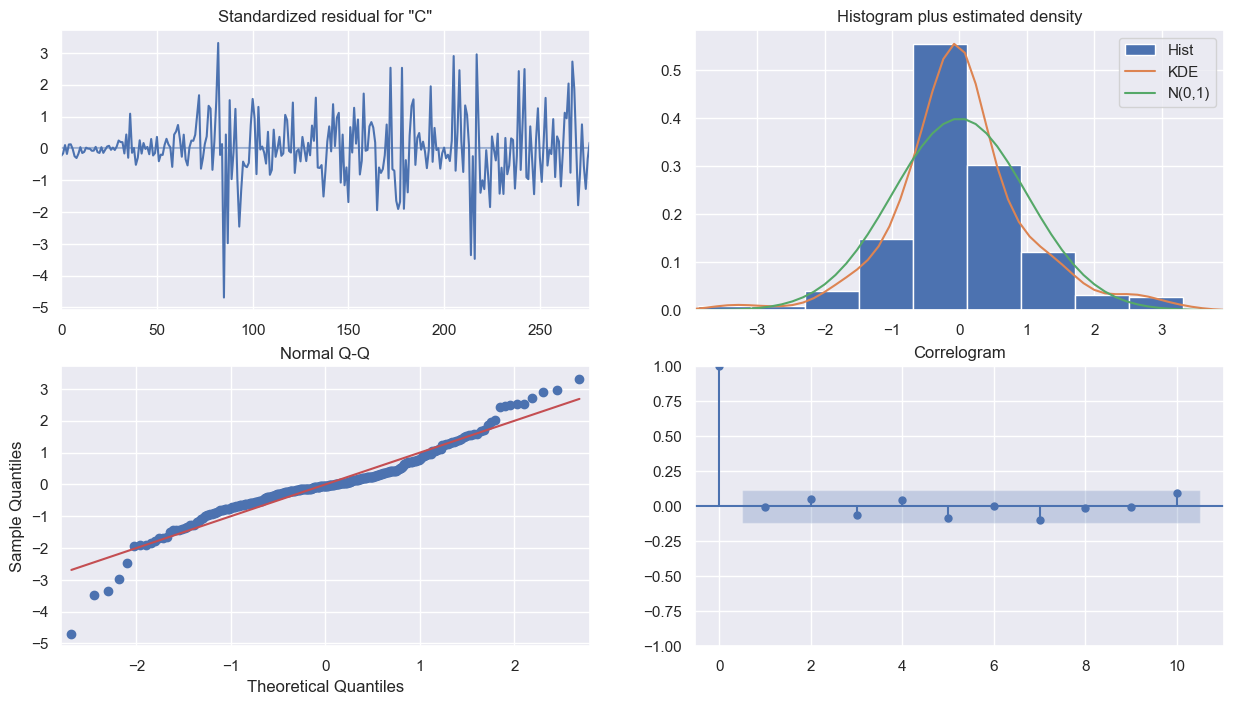

               Close
2024-01-30  3.798774
2024-02-28  4.058837
2024-03-27  4.086700
2024-04-29  4.337475
2024-05-30  4.662554
2024-06-27  4.588251
2024-07-30  4.689117
2024-08-29  5.134777
2024-09-27  4.860000
2024-10-30  4.360000
2024-11-28  4.170000
2024-12-11  4.300000
               Close
2024-01-30  3.789269
2024-02-28  3.801907
2024-03-27  3.814545
2024-04-29  3.827184
2024-05-30  3.839822
2024-06-27  3.852460
2024-07-30  3.865098
2024-08-29  3.877737
2024-09-27  3.890375
2024-10-30  3.903013
2024-11-28  3.915651
2024-12-11  3.928290


In [60]:
#train_data=pd.DataFrame() # splitting into test and train data
#test_data=pd.DataFrame() 
#validation = pd.DataFrame() 
#plt.figure(figsize=(12,8))

#train_data['Close'], test_data['Close'], validation['close'] = df['Close'][1:int(len(df['Close'])-5)], df['Close'][int(len(df)-5):int(len(df)-3)],df['Close'][int(len(df)-3):]
# 设定SARIMA模型的季节性参数 (P, D, Q, m)
# 例如，(1, 1, 1, 12) 表示季节性自回归、季节性差分和季节性滑动平均项，周期为12个月
seasonal_order = (0, 0, 0, 24)

# 创建SARIMAX模型
SARIMA = sm.tsa.SARIMAX(train_data['Close'], 
                       order=(0, 1, 1),         # 非季节性部分 (AR, I, MA)
                       seasonal_order=seasonal_order,  # 季节性部分 (P, D, Q, m)
                       trend='c')               # 线性趋势（如果你需要建模趋势的话）

# 拟合模型
results = SARIMA.fit()

# 打印模型摘要
print(results.summary())

# 进行预测
forecast = results.forecast(steps=len(test_data['Close']))


#forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Close']) # plot the predictions for validation set
#print(forecast.isna().sum())  # 查看是否有 NaN 值:0
# 确保forecast的索引与test_data的索引对齐
forecast_df = forecast.to_frame(name='Close')

# 如果需要对齐索引，确保索引匹配
forecast_df.index = test_data.index
'''
# 打印结果
plt.plot(train_data, label='Train {}'.format(['Close']))
plt.plot(test_data, label='Test {}'.format(['Close']))
plt.plot(forecast_df, label='Prediction {}'.format(['Close']))
plt.title('Stocks Price Prediction\n')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
'''
# 查看残差诊断
results.plot_diagnostics(figsize=(15, 8))
plt.show()

print(test_data)
print(forecast_df)

Still not working well, try other data preprocessing method

还是效果不好，尝试别的数据处理方式

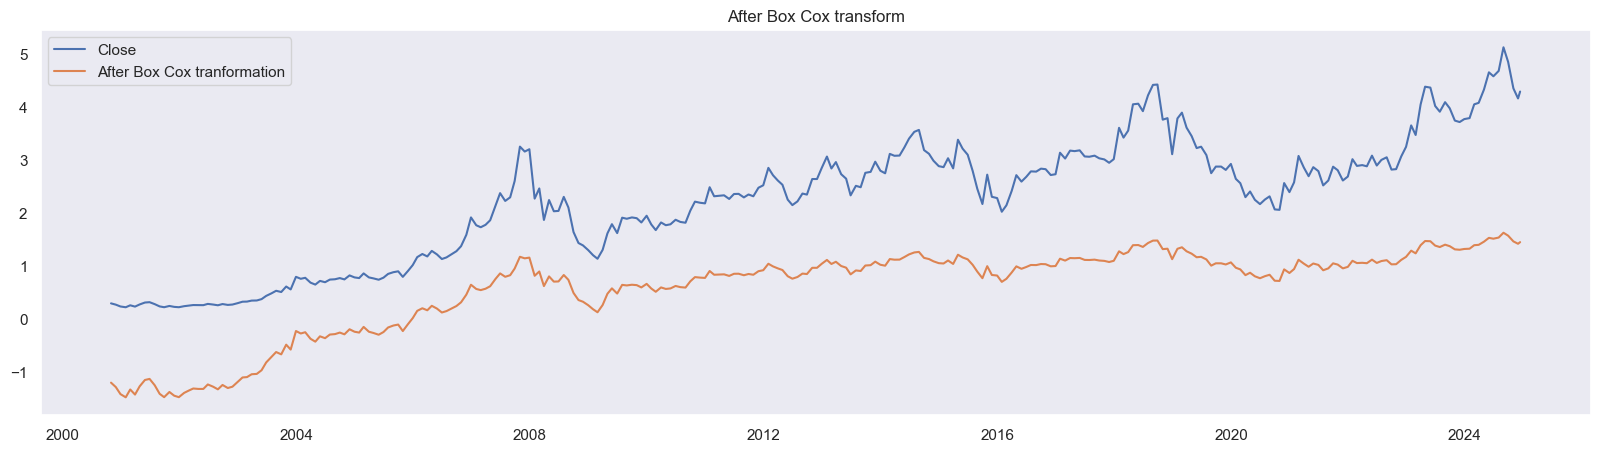

In [64]:
#Box Cox transformation to make variance constant
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(df['Close'], lmbda=0), index = df.index)#对数变换

df['Close'].plot(figsize=(20, 5))
plt.grid()
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

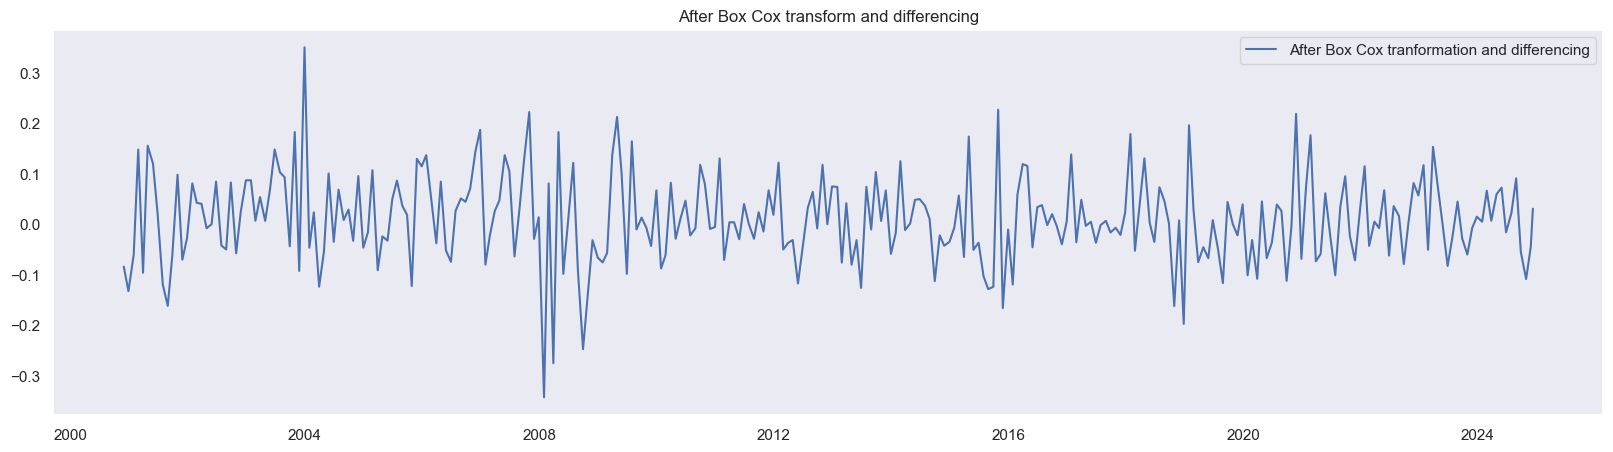

In [70]:
#Differencing to remove trend
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df.index) # first-order difference
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [72]:
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff

2000-11-29   -0.083964
2000-12-28   -0.132490
2001-01-30   -0.060104
2001-02-27    0.147810
2001-03-29   -0.096074
                ...   
2024-08-29    0.090792
2024-09-27   -0.054998
2024-10-30   -0.108566
2024-11-28   -0.044556
2024-12-11    0.030699
Length: 290, dtype: float64

Augmented Dickey-Fuller (ADF) test

In [75]:
result = adfuller(data_boxcox_diff, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
  print ("Reject Null Hypothesis. So, Time Series is Stationary")
else:
  print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
print("\n")

ADF Statistic: -11.531149
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Reject Null Hypothesis. So, Time Series is Stationary




Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test¶

In [80]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
  print ("Failed to reject Null Hypothesis. So, Time Series is Stationary")
else:
  print ("Reject Null Hypothesis. So, Time Series is Not-Stationary")
print("\n")

KPSS Statistic: 0.186015
Critical Values @ 0.05: 0.46
p-value: 0.100000
Failed to reject Null Hypothesis. So, Time Series is Stationary




C:\Users\123\AppData\Local\Temp\ipykernel_16600\2193799370.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data_boxcox_diff)


## Autocorrelation function (ACF)

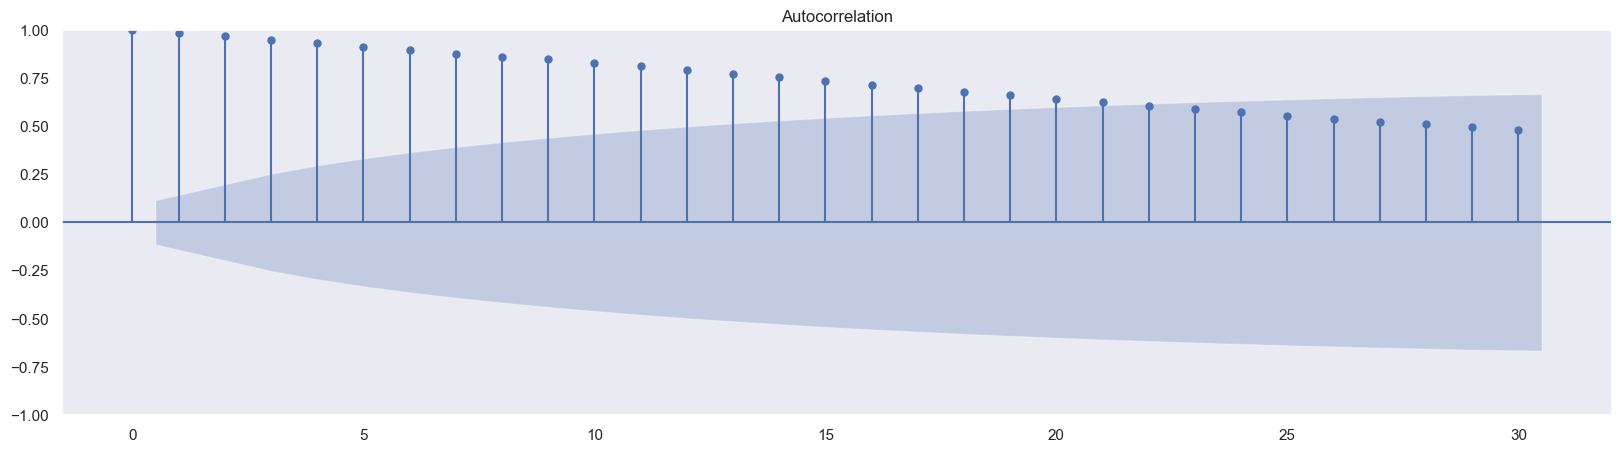

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(data_boxcox, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF)

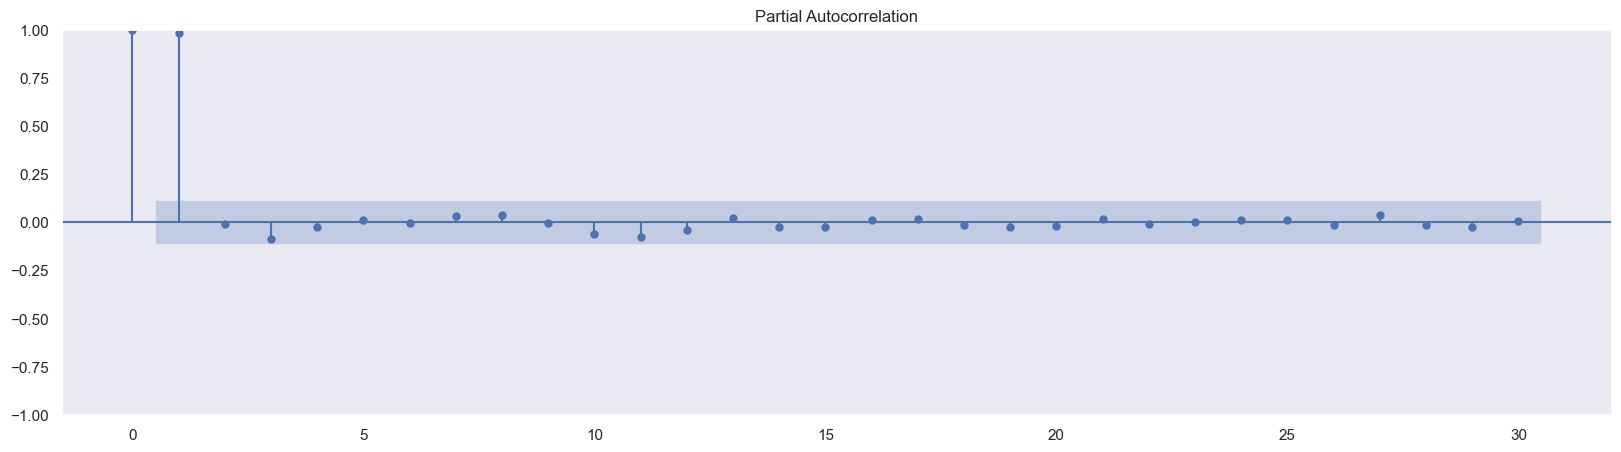

In [86]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_pacf(data_boxcox, ax=plt.gca(), lags = 30)
plt.show()

A high value at lag 1 in the PACF suggesting that the time series may have a strong first-order autocorrelation. This could imply the presence of a first-order autoregressive (AR) component in the model.

In [89]:
train_data=pd.DataFrame() # splitting into test and train data
test_data=pd.DataFrame() 
#validation = pd.DataFrame() 
plt.figure(figsize=(12,8))

train_data['Close'], test_data['Close']= df['Close'][:train_len], df['Close'][train_len:]

<Figure size 1200x800 with 0 Axes>

In [91]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]


In [93]:
test_data_boxcox

2024-01-30    1.334678
2024-02-28    1.400896
2024-03-27    1.407738
2024-04-29    1.467292
2024-05-30    1.539563
2024-06-27    1.523499
2024-07-30    1.545244
2024-08-29    1.636036
2024-09-27    1.581038
2024-10-30    1.472472
2024-11-28    1.427916
2024-12-11    1.458615
dtype: float64

## Seasonal auto regressive integrated moving average (SARIMA)

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.special import inv_boxcox

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ar.L1      -0.788943
ma.L1       0.707426
ar.S.L12    0.034928
ma.S.L12   -0.989323
sigma2      0.007896
dtype: float64


Recover original time series forecast

In [99]:
forecast_boxcox = model_fit.forecast(steps=len(test_data_boxcox))

# 还原到原始尺度（指数还原）
forecast_original = np.exp(forecast_boxcox)

# 评估
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data_boxcox, forecast_original)
print(f'MSE: {mse}')

MSE: 6.671574436309412


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [101]:
# 确保forecast的索引与test_data的索引对齐
forecast_df = forecast_original.to_frame(name='Close')

# 如果需要对齐索引，确保索引匹配
forecast_df.index = test_data_boxcox.index

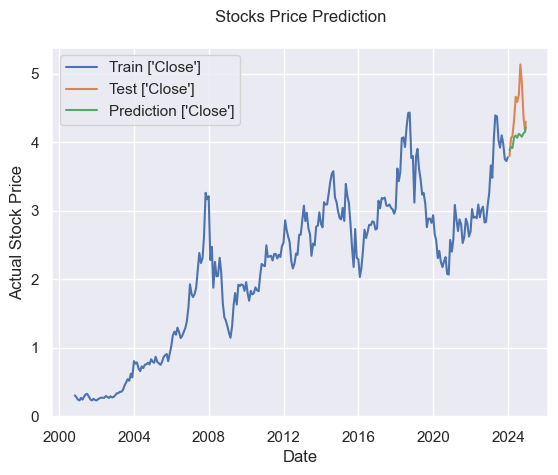

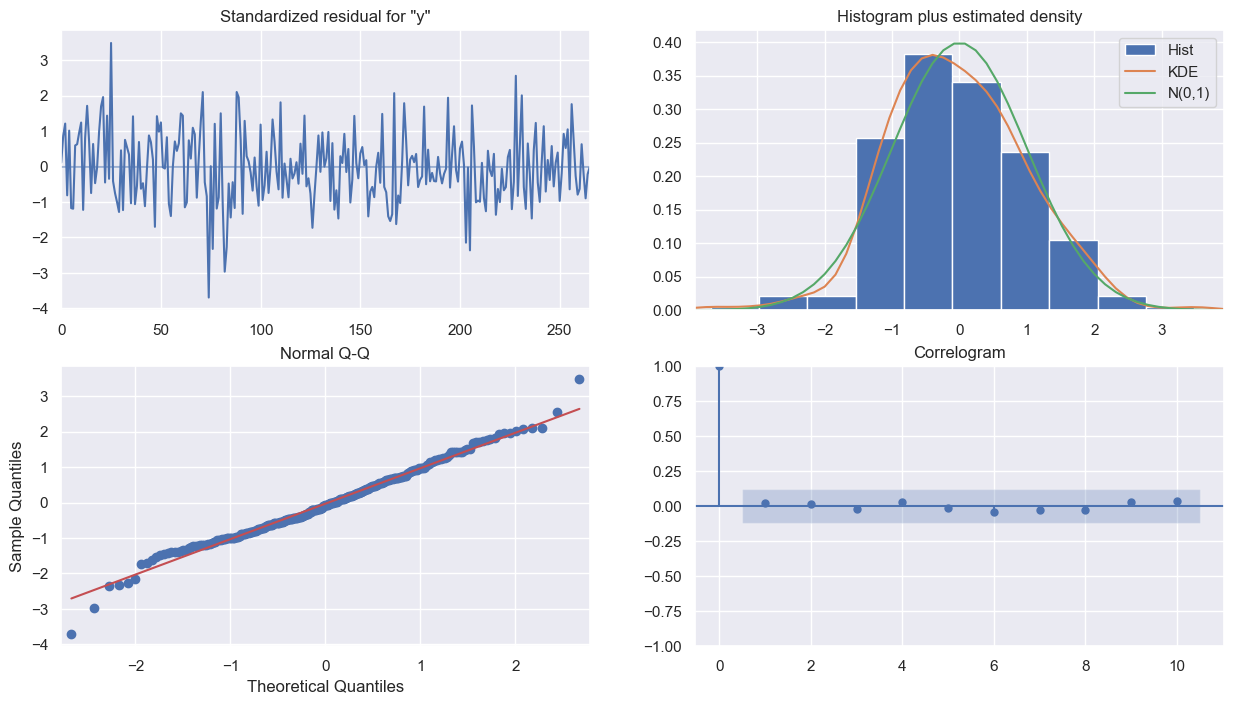

In [103]:
# 打印结果
plt.plot(train_data, label='Train {}'.format(['Close']))
plt.plot(test_data, label='Test {}'.format(['Close']))
plt.plot(forecast_df, label='Prediction {}'.format(['Close']))
plt.title('Stocks Price Prediction\n')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# 查看残差诊断
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

## 调参数 Find Suitable Parameters

In [225]:
import random
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 禁止所有警告
warnings.simplefilter("ignore")

# 设置随机种子，确保结果可复现
random.seed(42)  # 设置random模块的种子
np.random.seed(42)  # 设置numpy模块的种子

# 定义参数范围
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(0, 3)
seasonal_p_range = range(0, 3)
seasonal_d_range = range(0, 3)
seasonal_q_range = range(0, 3)
m_range = [12, 24]  # 假设季节性周期为12或24

best_aic = float('inf')
best_params = None

# 打印中间结果
print("开始随机搜索模型参数...\n")

for i in range(100):  # 随机选择100个组合
    p = random.choice(p_range)
    d = random.choice(d_range)
    q = random.choice(q_range)
    seasonal_p = random.choice(seasonal_p_range)
    seasonal_d = random.choice(seasonal_d_range)
    seasonal_q = random.choice(seasonal_q_range)
    m = random.choice(m_range)
    print(f"尝试参数组合 {i+1}: (p={p}, d={d}, q={q}, seasonal_p={seasonal_p}, seasonal_d={seasonal_d}, seasonal_q={seasonal_q}, m={m})")
    try:
        model = SARIMAX(train_data_boxcox,
                        order=(p, d, q),
                        seasonal_order=(seasonal_p, seasonal_d, seasonal_q, m))
        results = model.fit()
        #forecast = results.forecast(steps=len(test_data['Close']))
        
        
        # 获取AIC
        aic = results.aic
        print(f"  AIC = {aic}")
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q, seasonal_p, seasonal_d, seasonal_q, m)
            print(f"  新的最佳模型参数 (AIC: {best_aic})\n")

    except exception as e:
        print(f"  错误: {e}")
        continue

# 输出最终最佳参数
print("\n随机搜索完成！")
print(f"最优参数组合: {best_params}")
print(f"  最佳模型参数 (AIC: {best_aic})\n")

开始随机搜索模型参数...

尝试参数组合 1: (p=2, d=0, q=0, seasonal_p=2, seasonal_d=1, seasonal_q=0, m=12)
  AIC = -440.2812029440679
  新的最佳模型参数 (AIC: -440.2812029440679)

尝试参数组合 2: (p=0, d=2, q=0, seasonal_p=2, seasonal_d=2, seasonal_q=2, m=12)
  AIC = -189.98646801243788
尝试参数组合 3: (p=2, d=1, q=0, seasonal_p=0, seasonal_d=0, seasonal_q=0, m=12)
  AIC = -555.7104324414859
  新的最佳模型参数 (AIC: -555.7104324414859)

尝试参数组合 4: (p=2, d=2, q=0, seasonal_p=2, seasonal_d=0, seasonal_q=2, m=24)
  AIC = -476.7870411367031
尝试参数组合 5: (p=0, d=1, q=2, seasonal_p=1, seasonal_d=0, seasonal_q=0, m=24)
  AIC = -554.1878710973021
尝试参数组合 6: (p=1, d=1, q=0, seasonal_p=0, seasonal_d=1, seasonal_q=0, m=12)
  AIC = -356.134663464414
尝试参数组合 7: (p=1, d=0, q=1, seasonal_p=1, seasonal_d=2, seasonal_q=1, m=12)
  AIC = -340.1973939968941
尝试参数组合 8: (p=2, d=1, q=2, seasonal_p=0, seasonal_d=1, seasonal_q=0, m=24)
  AIC = -310.3835190730671
尝试参数组合 9: (p=2, d=2, q=1, seasonal_p=2, seasonal_d=0, seasonal_q=2, m=12)
  AIC = -541.4611340396124


The SARIMA model using the parameter with higherst AIC results in a straight line, it likely means the model is too simple or misspecified. The high AIC indicates that, despite having few parameters, the model is not capturing the underlying data patterns effectively. The straight line in the residuals suggests that the model fails to account for important trends or seasonality, leading to a poor fit. The high AIC penalizes the simplicity because it doesn't explain the data well enough, despite the low parameter count.

## Try to find suitable parameter by observing the pattern

C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

MSE: 10.451808028721073


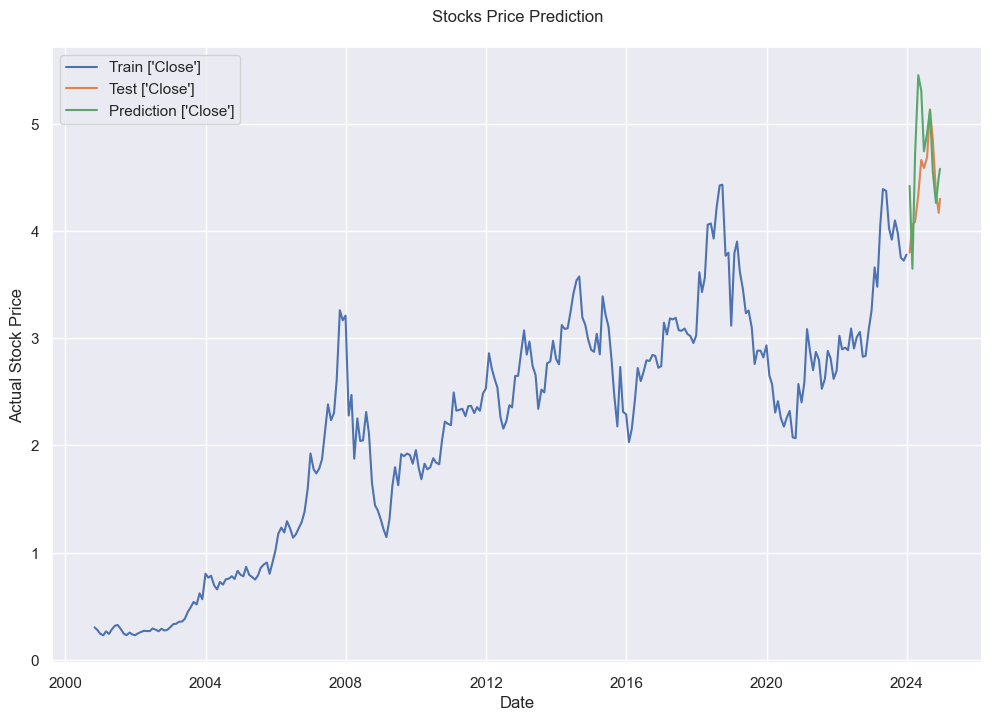

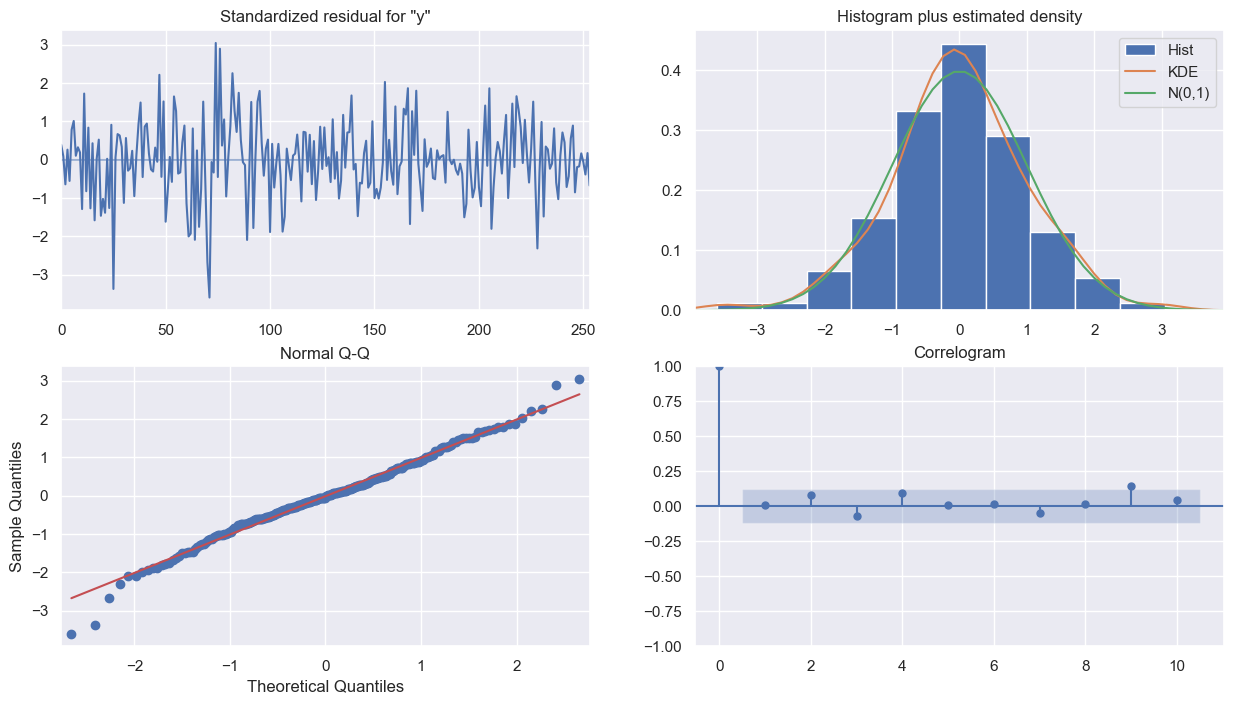

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  279
Model:             SARIMAX(1, 1, 0)x(1, 2, 0, 12)   Log Likelihood                  98.511
Date:                            Wed, 18 Dec 2024   AIC                           -191.021
Time:                                    16:53:27   BIC                           -180.409
Sample:                                         0   HQIC                          -186.752
                                            - 279                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1178      0.060     -1.978      0.048      -0.235      -0.001
ar.S.L12      -0.6255      0.047    -13.297      0.000      -0.718      -0.533
sigma2         0.0263      0.002     13.055      0.000       0.022       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 8.37
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):               0.44   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
from scipy.stats import boxcox
train_len = len(df['Close'])-12
test_len = len(df['Close'])-6
train_data=pd.DataFrame() # splitting into test and train data
test_data=pd.DataFrame() 
#validation = pd.DataFrame() 
plt.figure(figsize=(12,8))

train_data['Close'], test_data['Close']= df['Close'][:train_len], df['Close'][train_len:]
data_boxcox = pd.Series(boxcox(df['Close'], lmbda=0), index = df.index)#对数变换
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

model = SARIMAX(train_data_boxcox, order=(1, 1, 0), seasonal_order=(1, 2, 0, 12)) 
model_fit = model.fit()
forecast_boxcox = model_fit.forecast(steps=len(test_data_boxcox))

# 还原到原始尺度（指数还原）
forecast_original = np.exp(forecast_boxcox)

# 评估
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data_boxcox, forecast_original)
print(f'MSE: {mse}')
# 确保forecast的索引与test_data的索引对齐
forecast_df = forecast_original.to_frame(name='Close')

# 如果需要对齐索引，确保索引匹配
forecast_df.index = test_data_boxcox.index

# 打印结果
plt.plot(train_data, label='Train {}'.format(['Close']))
plt.plot(test_data, label='Test {}'.format(['Close']))
plt.plot(forecast_df, label='Prediction {}'.format(['Close']))
plt.title('Stocks Price Prediction\n')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



# 查看残差诊断
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

model_fit.summary()

## 1. Parameter Estimation  
### Autoregressive Term (AR.L1):  
   - The coefficient is −0.1178, indicating a small negative influence of the non-seasonal autoregressive term on the previous time point.  
   - The p-value is 0.048, close to the significance level of 0.05, suggesting that this parameter is statistically significant.  

### Seasonal Autoregressive Term (AR.S.L12):  
   - The coefficient is −0.6255, with a very high significance (p-value = 0.000), indicating a significant negative correlation between the seasonal autoregressive term and the current value.  

### Residual Variance (sigma2):  
   - The value is 0.0263, which measures the volatility of residuals after fitting the model, suggesting that the model explains most of the volatility and the residuals are small.  
   - The p-value is 0.000, indicating that this residual term is significant.  

## 2. Model Evaluation Metrics  
   - **AIC (Akaike Information Criterion)**: -191.021  
     This low value generally indicates that the model strikes a good balance when fitting the data. A lower AIC typically signals a better model.  
   - **BIC (Bayesian Information Criterion)**: −180.409  
     The BIC value is also low. While AIC favors model fit, BIC imposes a stricter penalty for model complexity, suggesting a reasonable compromise between the model’s fit and its complexity.  
   - **HQIC (Hannan-Quinn Information Criterion)**: −186.752  
     The HQIC value is similar to AIC and BIC, further supporting the validity of the model.  

## 3. Residual Diagnostics  
   - **Ljung-Box Test**:  
     Q=0.03, p=0.87  
     This shows that the residuals do not exhibit significant autocorrelation, supporting the hypothesis of white noise.  
     **Conclusion**: Residual autocorrelation is very low, suggesting a good model fit.  
   - **Jarque-Bera Test**:  
     JB=8.37, p=0.02  
     This indicates that the residuals' distribution deviates from normality, but not severely (the p-value is close to 0.05, suggesting possible mild skewness or kurtosis issues).  
     **Conclusion**: The normality of the residuals is slightly off, but the impact is minimal.  
   - **Heteroskedasticity Test**:  
     H=0.44, p<0.0001  
     This indicates significant heteroskedasticity, meaning the volatility of the model's residuals is not stable, which could affect some types of forecast results.  
     **Conclusion**: The significance of heteroskedasticity suggests that the residual volatility varies over time, potentially affecting the model’s stability.  
   - **Skewness and Kurtosis**:  
     - Skewness: −0.15, which is close to symmetric, indicating a balanced distribution of the data.  
     - Kurtosis: Slightly higher than the theoretical value of 3 for a normal distribution, suggesting the data distribution is slightly leptokurtic (more peaked).  

## 4. Conclusion  
   - **Strengths**:  
     - The seasonal autoregressive term (AR.S.L12) is highly significant and has a reasonable negative correlation.  
     - The AIC and BIC values indicate that the model is relatively strong with good fit.  
     - Residual autocorrelation and heteroskedasticity tests show that the model effectively captures the time series characteristics.  
   - **Weaknesses**:  
     - The normality is slightly off. While the skewness and kurtosis are not severe, the Jarque-Bera test shows residuals deviate from normal distribution, which could affect the model's confidence intervals.  
     - There is significant heteroskedasticity, which may impact the accuracy of future predictions. Consider using a GARCH model to address this issue.  

## 5. Suggestions for Improvement  
   - To address heteroskedasticity, consider including other relevant data or using the SARIMAX model. Alternatively, you could explore using a GARCH model to handle residual volatility.  
   - Overall, the model performs well but requires further improvement to address heteroskedasticity and normality issues in the residuals.  

### 1. Residual Variance Varies Over Time  
   Heteroskedasticity refers to the changing volatility of errors (residuals) over time. Ideally, in time series models, we expect the residual volatility to be constant (i.e., homoskedasticity). If the residual variance changes over time, it indicates that the model may not have fully captured all structural features in the data.  

### 2. Possible Causes  
   - **Economic or Financial Data**: In financial markets, volatility can vary during certain periods (e.g., market crises), while other periods exhibit lower volatility. Traditional SARIMA models might not capture these changing volatility patterns well.  
   - **External Influences**: External factors (such as sudden events, seasonal effects, etc.) may cause volatility to be higher during some periods and lower during others, leading to heteroskedasticity.  


## 1. 参数估计
### 自回归项 (AR.L1):

    系数为−0.1178，表示该模型的非季节性自回归项对前一期的影响较小（负相关）。
    P值为 0.048，接近显著性水平0.05，表明该参数具有一定的统计显著性。

### 季节性自回归项 (AR.S.L12):

    系数为 −0.6255，显著性很高（P值为 0.000），表明季节性自回归对当前值的影响显著，并且为负相关。

### 残差方差 (sigma2):

    值为 0.0263，这个值是对模型拟合后残差波动性的度量，表明模型解释了大部分的波动性，且残差较小。
    P值为 0.000，表明该残差项是显著的。
## 2. 模型评价指标
    AIC（赤池信息准则）: -191.021
        这个值较低，通常表明模型在拟合数据时具有较好的平衡，较低的AIC值是模型优越的标志。
    BIC（贝叶斯信息准则）: −180.409
        BIC值也较低，虽然AIC偏向于拟合优度，但BIC对模型复杂度有更严格的惩罚，这也表明该模型在数据复杂度上做出了合理的折衷。
    HQIC（Hannan-Quinn信息准则）: −186.752
        HQIC值与AIC和BIC相似，继续支持模型的有效性。
## 3. 残差诊断
    Ljung-Box检验:
        Q=0.03，𝑃=0.87
        表明模型的残差没有显著的自相关性，适合假设白噪声。
        结论: 残差自相关性非常低，模型拟合较好。
    Jarque-Bera检验:
        JB=8.37，P=0.02
        表明残差的分布偏离正态分布，但并不严重（P值接近0.05，表明可能存在轻微的偏度或峰度问题）。
        结论: 残差的正态性稍差，但影响不大。
    异方差性检验 (Heteroskedasticity):
        H=0.44，P<0.0001
        表明存在显著的异方差性，这意味着模型残差的波动性不稳定，可能对某些类型的预测结果产生影响。
        异方差性检验的显著性说明不同时间段的残差波动不同，可能影响模型的稳定性。
    偏度与峰度:
        偏度: −0.15，接近对称，表示数据的分布较为平衡。
        峰度:略高于正态分布的理论值3，表明数据的分布略显尖峰。
## 4. 结论
    优点:
        模型的季节性自回归成分（AR.S.L12）非常显著，且具有合适的负相关性。
        模型的AIC和BIC都表明模型相对优秀，拟合效果较好。
        残差的自相关性和异方差性检验较好，表明模型在捕捉时间序列特征方面的有效性。
    不足:

        正态性略差，虽然偏度和峰度指标并不严重，但Jarque-Bera检验显示残差偏离正态分布，可能影响模型的置信区间。
        异方差性显著，可能影响未来预测的准确性，需要考虑用GARCH模型来改善。
## 5. 改进建议
    针对异方差性，可以考虑加入其它相关数据，改用SARIMAX模型，也可以考虑使用 GARCH 模型来处理残差波动性,。
    总体来说，这个模型表现良好，但对残差的异方差性和正态性问题需要进一步的改进。

### 1. 残差的方差随着时间变化
    异方差性是指不同时间点的误差（残差）的波动性不同。在时间序列模型中，理想情况下，我们期望残差的波动性是稳定的（即 同方差性）。如果残差的方差随着时间发生变化，则表明模型可能没有完全捕捉到数据的所有结构特征。
### 2. 可能的原因
经济或金融数据：在金融市场中，某些时段可能会有更大的波动性（例如，市场危机时波动加剧），而在其他时段波动较小。此时，传统的SARIMA模型可能无法很好地捕捉这种波动性变化。
外部因素影响：某些外部因素（如突发事件、季节性效应等）可能导致某些时期的波动性较大，而其他时期则较为平稳。

In [116]:
type(forecast_boxcox)

pandas.core.series.Series

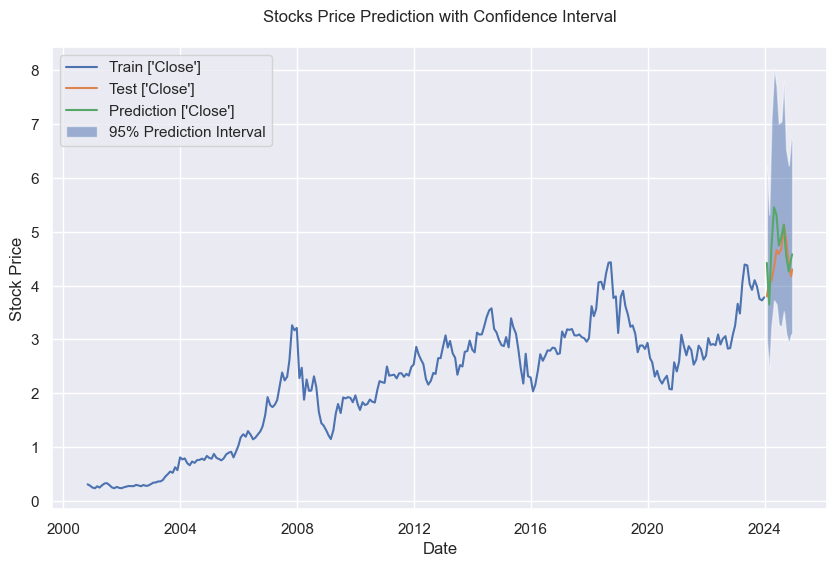

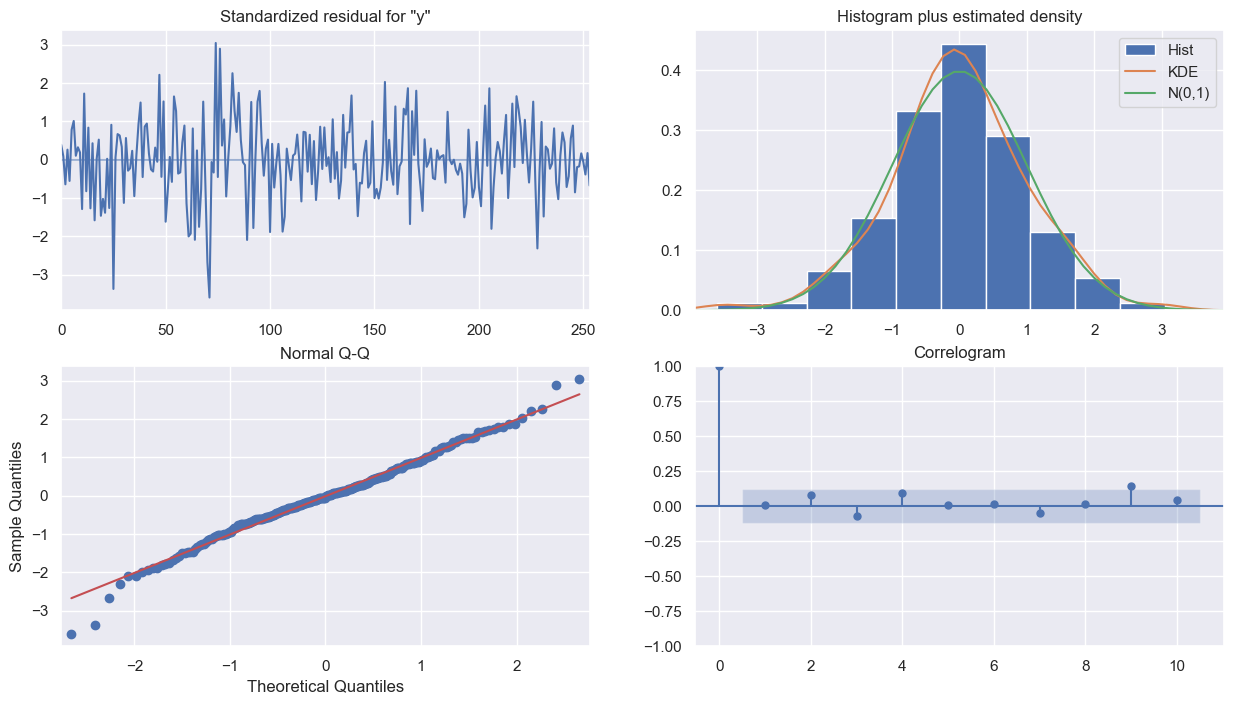

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  279
Model:             SARIMAX(1, 1, 0)x(1, 2, 0, 12)   Log Likelihood                  98.511
Date:                            Wed, 18 Dec 2024   AIC                           -191.021
Time:                                    17:01:23   BIC                           -180.409
Sample:                                         0   HQIC                          -186.752
                                            - 279                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1178      0.060     -1.978      0.048      -0.235      -0.001
ar.S.L12      -0.6255      0.047   

In [128]:
# 将预测结果转化为 numpy 数组
# Convert forecast values to numpy array
forecast_boxcox_values = forecast_boxcox  

# 蒙特卡洛模拟：生成多个预测路径
# Set the number of simulations
num_simulations = 1000  
simulated_forecasts = []

# 进行模拟预测
# Simulate the forecast
for _ in range(num_simulations):
    # 从模型的残差中生成随机误差
    # Generate random error from model residuals
    random_error = np.random.normal(loc=0, scale=model_fit.resid.std(), size=len(test_data_boxcox))
    # 添加误差生成模拟预测路径
    # Add error to generate simulated forecast paths
    simulated_forecasts.append(forecast_boxcox_values + random_error)

# 将模拟结果转换为数组
# Convert the simulated forecasts to an array
simulated_forecasts = np.array(simulated_forecasts)

# 计算模拟预测值的置信区间（例如95%置信区间）
# Calculate the lower and upper bounds of the 95% confidence interval
lower_bound = np.percentile(simulated_forecasts, 2.5, axis=0)  
upper_bound = np.percentile(simulated_forecasts, 97.5, axis=0)  

# 还原到原始尺度
# Convert the lower and upper bounds back to the original scale
lower_bound_original = np.exp(lower_bound)  
upper_bound_original = np.exp(upper_bound)  

# 绘图：训练数据、测试数据、预测数据和预测区间
# Plot the training data, test data, forecasted data, and prediction intervals
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Train {}'.format(['Close']))  
plt.plot(test_data, label='Test {}'.format(['Close']))  
plt.plot(forecast_df, label='Prediction {}'.format(['Close']))  

# 绘制预测区间（95%置信区间）
# Plot the 95% prediction interval
plt.fill_between(forecast_df.index, lower_bound_original, upper_bound_original, 
                 alpha=0.5, label='95% Prediction Interval')  

plt.title('Stocks Price Prediction with Confidence Interval\n')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()

# 打印模型的残差诊断图
# Plot the model's residual diagnostics
model_fit.plot_diagnostics(figsize=(15, 8))  
plt.show()

# 打印模型的总结
# Print the model summary
print(model_fit.summary())  


The range of the results is too broad to be meaningful.

## Calculate Probability to hit 110% using Monte Carlo Simulation

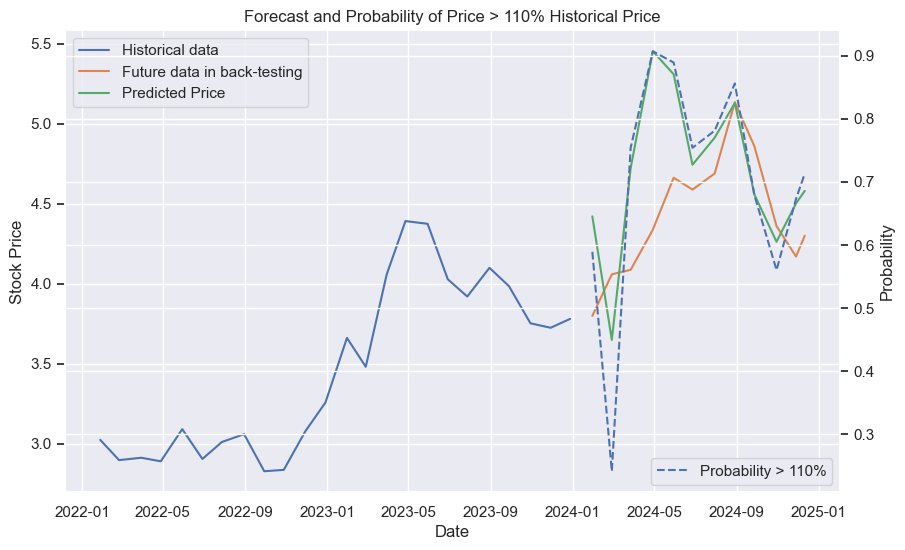

            Probability
Date                   
2024-01-30        0.589
2024-02-28        0.241
2024-03-27        0.754
2024-04-29        0.907
2024-05-30        0.889
2024-06-27        0.754
2024-07-30        0.781
2024-08-29        0.856
2024-09-27        0.679
2024-10-30        0.560
2024-11-28        0.673
2024-12-11        0.713


In [130]:
# 提取预测值（对数尺度）
# Extract forecast values (log scale)
forecast_boxcox_values = forecast_boxcox

# 蒙特卡洛模拟：生成多个预测路径
# Monte Carlo simulation: Generate multiple forecast paths
num_simulations = 1000  # 模拟次数
# Set the number of simulations
simulated_forecasts = []

for _ in range(num_simulations):
    # 从模型的残差中生成随机误差
    # Generate random error from model residuals
    random_error = np.random.normal(loc=0, scale=model_fit.resid.std(), size=len(test_data_boxcox))
    # 添加误差生成模拟预测路径
    # Add the error to generate simulated forecast paths
    simulated_forecasts.append(forecast_boxcox_values.values + random_error)

# 将模拟结果转为原始尺度
# Convert the simulated forecasts back to the original scale
simulated_forecasts = np.exp(np.array(simulated_forecasts))  # (num_simulations, len(test_data_boxcox))

# 定义计算概率的条件：价格为最近历史价格的110%
# Define the condition to calculate probability: price is 110% of the latest historical price
historical_price = train_data.iloc[-1]  # 最近历史价格
# Latest historical price
threshold = historical_price * 1.1  # 110%的阈值
# 110% threshold

# 将阈值扩展为与 simulated_forecasts 形状一致
# Extend the threshold to match the shape of simulated_forecasts
threshold_array = np.full_like(simulated_forecasts, fill_value=threshold)

# 计算满足条件的概率
# Calculate the probability of exceeding the threshold
probabilities = (simulated_forecasts > threshold_array).mean(axis=0)

# 计算满足条件的概率（逐时间点）
# Calculate the probability (at each time point)
probabilities = (simulated_forecasts > threshold_array).mean(axis=0)  # 平均值即为概率
# Mean value is the probability

# 转换为 DataFrame，方便展示
# Convert to DataFrame for easier display
probabilities_df = pd.DataFrame({
    'Date': test_data.index,
    'Probability': probabilities
}).set_index('Date')

# 绘图：预测价格与满足条件的概率
# Plot: Forecasted price and probability of exceeding the condition
plt.figure(figsize=(10, 6))
plt.plot(train_data[-24:], label='Historical data')  # 最近24个历史数据
# Plot the last 24 historical data points
plt.plot(test_data, label='Future data in back-testing')  # 测试数据
# Plot the test data
plt.plot(forecast_df, label='Predicted Price')  # 预测数据
# Plot the forecasted data
# plt.fill_between(forecast_df.index, forecast_df['Close'], forecast_df['Close'], color='gray', alpha=0.3)
plt.title('Forecast and Probability of Price > 110% Historical Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.twinx()  # 添加第二坐标轴绘制概率
# Add a second y-axis to plot the probability
plt.plot(probabilities_df.index, probabilities_df['Probability'], label='Probability > 110%', linestyle='--')
plt.ylabel('Probability')
plt.legend(loc='lower right')
plt.show()
# Display the plot
print(probabilities_df)  # 打印概率结果


### 生成一年的110%，t+2价格预测 
### Generate a 110% one-year, t+2 price forecast.

In [133]:
# 初始化结果存储的DataFrame
# Initialize a DataFrame to store results
result_110percent_hit_df = pd.DataFrame(columns=['actual_price', 'predicted_price', 'prob_hit110%'])

# 遍历时间序列，从 `len(df) - 13` 开始预测
# Iterate through the time series, starting predictions from `len(df) - 13`
len_train = len(df) - 13
for i in range(len_train, len(df)):
    # 定义训练和测试数据集
    # Define training and test datasets
    train_data = df['Close'][:i]
    test_data = df['Close'][i:i+2]

    # Box-Cox变换后的训练和测试数据
    # Box-Cox transformed training and test data
    train_data_boxcox = data_boxcox[:i]
    test_data_boxcox = data_boxcox[i:i+2]

    # 定义SARIMAX模型
    # Define the SARIMAX model
    model = SARIMAX(train_data_boxcox, order=(1, 1, 0), seasonal_order=(1, 2, 0, 12))
    model_fit = model.fit()

    # 预测未来两个月的值
    # Forecast the next two months' values
    forecast_boxcox = model_fit.forecast(steps=2)

    # 将Box-Cox预测值还原到原始尺度
    # Convert Box-Cox forecast values back to original scale
    forecast_original = np.exp(forecast_boxcox)
    #print(forecast_original)

    # 确保预测值的索引与测试数据对齐
    # Ensure the forecast index aligns with the test data
    forecast_df = pd.DataFrame({'predicted_price': forecast_original})
    #forecast_df.index = test_data.index[:len(forecast_original)]
    #print(forecast_df)

    # 存储最后一个月的实际值和预测值
    # Store the actual and predicted prices for the last month
    last_month_idx = test_data.index[-1]
    actual_price = test_data.iloc[-1]
    predicted_price = forecast_df.iloc[-1]['predicted_price']
    #print(predicted_price)

    # 提取预测值（对数尺度）
    # Extract forecast values (log scale)
    forecast_boxcox_values = forecast_boxcox
    
    # 蒙特卡洛模拟：生成多个预测路径
    # Monte Carlo simulation: Generate multiple forecast paths
    num_simulations = 1000  # 模拟次数
    # Set the number of simulations
    simulated_forecasts = []
    
    for _ in range(num_simulations):
        # 从模型的残差中生成随机误差
        # Generate random error from model residuals
        random_error = np.random.normal(loc=0, scale=model_fit.resid.std(), size=len(test_data_boxcox))
        # 添加误差生成模拟预测路径
        # Add the error to generate simulated forecast paths
        simulated_forecasts.append(forecast_boxcox_values.values + random_error)
    
    # 将模拟结果转为原始尺度
    # Convert the simulated forecasts back to the original scale
    simulated_forecasts = np.exp(np.array(simulated_forecasts))  # (num_simulations, len(test_data_boxcox))
    
    # 定义计算概率的条件：价格为最近历史价格的110%
    # Define the condition to calculate probability: price is 110% of the latest historical price
    historical_price = train_data.iloc[-1]  # 最近历史价格
    # Latest historical price
    threshold = historical_price * 1.1  # 110%的阈值
    # 110% threshold
    
    # 将阈值扩展为与 simulated_forecasts 形状一致
    # Extend the threshold to match the shape of simulated_forecasts
    threshold_array = np.full_like(simulated_forecasts, fill_value=threshold)
    
    # 计算满足条件的概率
    # Calculate the probability of exceeding the threshold
    probabilities = (simulated_forecasts > threshold_array).mean(axis=0)
    #print(probabilities[1])
    
    # 计算满足条件的概率（逐时间点）
    # Calculate the probability (at each time point)
    probabilities = (simulated_forecasts > threshold_array).mean(axis=0)  # 平均值即为概率
    # Mean value is the probability
    # 模拟计算命中110%的概率
    # Simulate the probability of hitting 110%
    prob_hit110 = probabilities[1]  # 示例概率

    #print(type(prob_hit110))

    # 创建一行新的结果
    # Create a new row for the result
    new_row = pd.DataFrame({
        'actual_price': [actual_price],
        'predicted_price': [predicted_price],
        'threshould': [threshold],
        'bool_hit': [actual_price >= threshold],
        'prob_hit110%': [prob_hit110]
    }, index=[last_month_idx])

    # 使用 pd.concat 更新结果 DataFrame
    # Update the result DataFrame using pd.concat
    result_110percent_hit_df = pd.concat([result_110percent_hit_df, new_row])


C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\envs\ARIMAenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

In [135]:
print(result_110percent_hit_df)

            actual_price  predicted_price  prob_hit110%  threshould bool_hit
2024-01-30      3.798774         4.868746         0.815    4.096917    False
2024-02-28      4.058837         3.648866         0.270    4.158218    False
2024-03-27      4.086700         4.121370         0.462    4.178651    False
2024-04-29      4.337475         5.906278         0.935    4.464721    False
2024-05-30      4.662554         4.725055         0.589    4.495370     True
2024-06-27      4.588251         3.807327         0.133    4.771223    False
2024-07-30      4.689117         4.266239         0.176    5.128809    False
2024-08-29      5.134777         4.908310         0.452    5.047076     True
2024-09-27      4.860000         4.358839         0.172    5.158029    False
2024-10-30      4.360000         4.245789         0.075    5.648255    False
2024-11-28      4.170000         4.763096         0.260    5.346000    False
2024-12-11      4.300000         4.701270         0.452    4.796000    False

In [100]:
result_110percent_hit_df.to_csv("prob_hit_110.csv")

## --------------------------------------Seperate Line Draft--------------------------------------

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

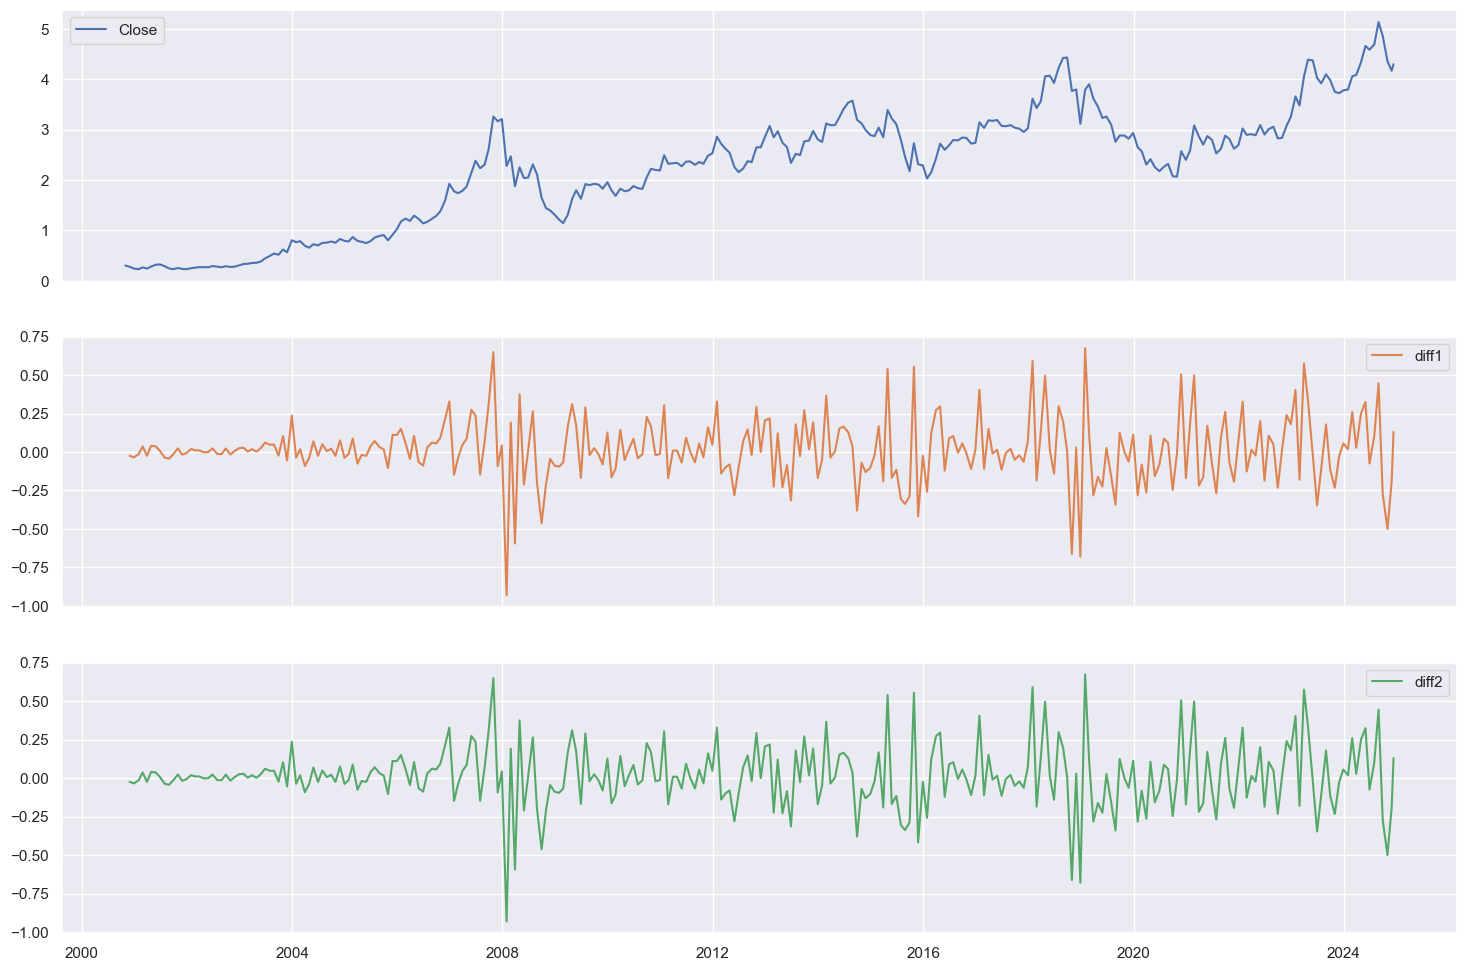

In [139]:
#diff1=pd.DataFrame() # splitting into test and train data
#diff2=pd.DataFrame()
temp = pd.DataFrame()
temp['Close'] = df['Close']
temp['diff1']=df['Close'].diff(1).dropna()
temp['diff2']=df['Close'].diff(1).dropna()
temp.plot(subplots= True, figsize=(18,12))

In [341]:
from arch.unitroot import ADF
print(ADF(temp.diff1.dropna()))

   Augmented Dickey-Fuller Results   
Test Statistic                -18.404
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [344]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df_log2, lags = [i for i in range(1,12)],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,1.326422,0.249443,1.312795,0.251889
2,3.389667,0.183630,3.347776,0.187517
3,4.765646,0.189784,4.700193,0.195114
4,5.287103,0.259087,5.210935,0.266331
5,6.530217,0.257987,6.424249,0.267097
6,6.539005,0.365588,6.432796,0.376492
7,7.216141,0.406728,7.089062,0.419666
8,7.220884,0.512999,7.093642,0.526564
9,7.717370,0.562860,7.571424,0.577844
10,8.163979,0.612823,7.999680,0.628868


以上结果p value很大，说明即使做了差分，数据仍被认为是白噪声，这意味着序列的随机性较高，难以通过ARIMA建模捕捉其模式。尝试加入季节性因素

In [347]:
df

,Close
Date,
2000-10,0.303460
2000-11,0.279021
2000-12,0.244398
2001-01,0.230141
2001-02,0.266801
...,...
2024-08,5.134777
2024-09,4.860000
2024-10,4.360000


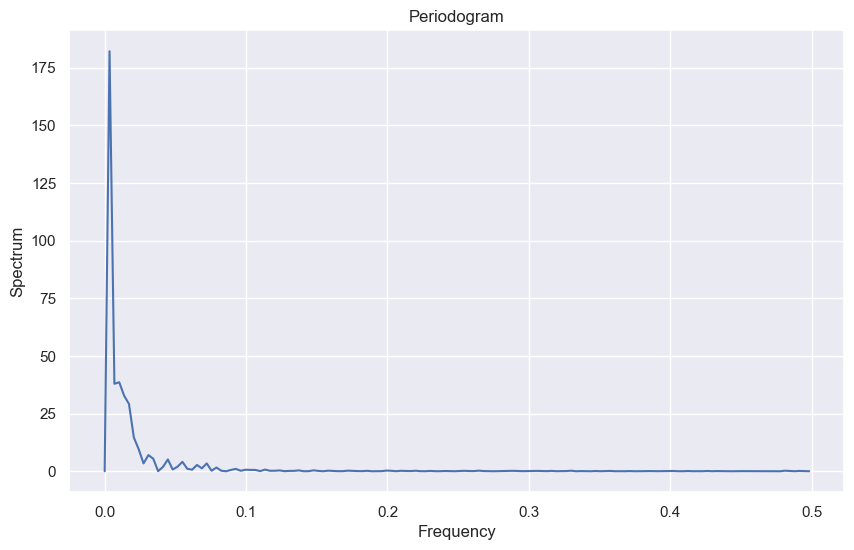

In [66]:
from scipy.signal import periodogram
#df_plot = df.copy()
#df_plot.index = pd.to_datetime(df.index).to_period('M')
freqs, spectrum = periodogram(df['Close'], fs=1)  # fs=1表示每单位时间一个采样
plt.plot(freqs, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.title('Periodogram')
plt.show()

In [355]:
freqs

array([0.        , 0.00343643, 0.00687285, 0.01030928, 0.0137457 ,
       0.01718213, 0.02061856, 0.02405498, 0.02749141, 0.03092784,
       0.03436426, 0.03780069, 0.04123711, 0.04467354, 0.04810997,
       0.05154639, 0.05498282, 0.05841924, 0.06185567, 0.0652921 ,
       0.06872852, 0.07216495, 0.07560137, 0.0790378 , 0.08247423,
       0.08591065, 0.08934708, 0.09278351, 0.09621993, 0.09965636,
       0.10309278, 0.10652921, 0.10996564, 0.11340206, 0.11683849,
       0.12027491, 0.12371134, 0.12714777, 0.13058419, 0.13402062,
       0.13745704, 0.14089347, 0.1443299 , 0.14776632, 0.15120275,
       0.15463918, 0.1580756 , 0.16151203, 0.16494845, 0.16838488,
       0.17182131, 0.17525773, 0.17869416, 0.18213058, 0.18556701,
       0.18900344, 0.19243986, 0.19587629, 0.19931271, 0.20274914,
       0.20618557, 0.20962199, 0.21305842, 0.21649485, 0.21993127,
       0.2233677 , 0.22680412, 0.23024055, 0.23367698, 0.2371134 ,
       0.24054983, 0.24398625, 0.24742268, 0.25085911, 0.25429

In [357]:
spectrum

array([3.58511528e-31, 1.82142948e+02, 3.79298964e+01, 3.85928801e+01,
       3.27743850e+01, 2.91820255e+01, 1.46795105e+01, 9.55670885e+00,
       3.40767173e+00, 7.00319334e+00, 5.43206147e+00, 3.75155033e-02,
       1.91052346e+00, 5.11298340e+00, 7.64667469e-01, 1.99242366e+00,
       4.08912556e+00, 1.07131812e+00, 6.74372938e-01, 2.72493422e+00,
       1.27132929e+00, 3.39193439e+00, 2.20713359e-01, 1.62542485e+00,
       2.17049648e-01, 1.69964865e-03, 5.80982573e-01, 1.01642872e+00,
       2.05697355e-01, 6.69465622e-01, 5.68359024e-01, 5.77708979e-01,
       6.06636345e-02, 7.24045848e-01, 2.14357524e-01, 2.19793971e-01,
       3.56563422e-01, 4.33260677e-02, 1.44985432e-01, 1.78500665e-01,
       3.66509739e-01, 2.13419728e-03, 4.60643581e-02, 3.90949809e-01,
       1.47362658e-01, 1.53796371e-02, 2.42710019e-01, 1.36142535e-01,
       4.39345512e-02, 4.49915745e-02, 2.52117586e-01, 1.44190275e-01,
       8.30055747e-02, 4.84310448e-02, 1.89302241e-01, 2.20447819e-03,
      